# Lab Journal
## Alan Boles, Ganusov Lab

In [4]:
library(magrittr)

df1 <- 
read.delim("/Users/alanboles/Desktop/Research/tcelltxt/100908.txt", header = T) %>%
print



   population group         LN      t.0  t.12 t.18 t.24     t.36
1         CD4    WT   inguinal 12000.00  7420 3720 1050  989.820
2         CD4    WT   inguinal  9570.00  4840  523  240       NA
3         CD4    WT   inguinal 19502.60  5680 4150 1880 1394.748
4         CD4    WT   brachial  8130.00  6550 2320 1240  470.400
5         CD4    WT   brachial 20300.00  3790 1470  124       NA
6         CD4    WT   brachial 21399.30  8420 2170  732  579.500
7         CD4    WT mesenteric 42500.00 12000 5350 1930 3038.490
8         CD4    WT mesenteric 24200.00 24800 4420 1400       NA
9         CD4    WT mesenteric 63292.32 17800 8220 2810 3653.130
10        CD8    WT   inguinal  6660.00  6540 3720 1290 2353.572
11        CD8    WT   inguinal  5110.00  3400  507  240       NA
12        CD8    WT   inguinal 12303.20  4510 4900 2240 2622.828
13        CD8    WT   brachial  5000.00  5410 2770 1970 1186.500
14        CD8    WT   brachial 11900.00  3170 1620  148       NA
15        CD8    WT   bra

This data is readings of loss of T cells from lymphnodes in mice at 0, 6, 11, 25, 33 hours. The following code will plot the small dataset (sept 25 2020)

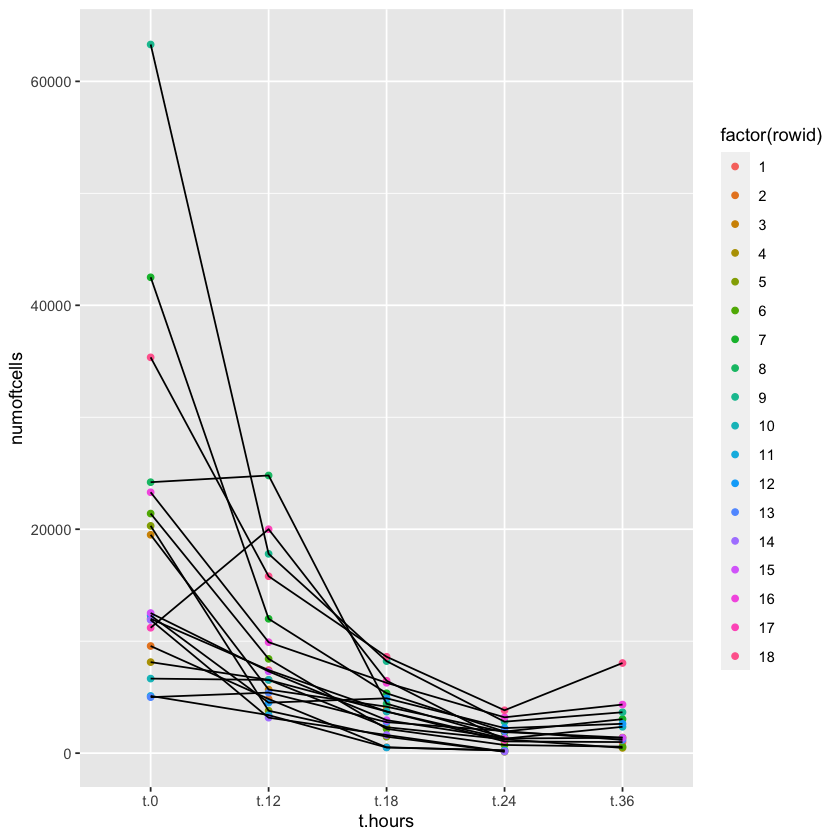

In [5]:
library(ggplot2)
library(dplyr)
library(tidyr)

df1<-
    df1 %>%
    gather(variable, value, -population,-group,-LN)# all are of group WT

df1$rowid <- 1:18 
df1$variable <- 
    as.character(df1$variable) %>%
    factor(.,levels=unique(.))


df1 %>%
dplyr::rename(., numoftcells = value, t.hours = variable) %>%
ggplot(., aes(t.hours, numoftcells), group=rowid) + 
    geom_point(aes(color=factor(rowid)), na.rm =T) + 
    geom_line(aes(group=rowid), na.rm = T)

Now I have plotted one data set I will apply this code to the file with all the data. (Oct 2 2020)

Can I write a function that reads in any of the txt files and plots it?

In [8]:
library(stringr)
library(ggpubr)
library(scales)
        
readandplot <- function(filename){
    df <- read.delim(filename, header = T) #read in txt file
    LNtypes <- c("brachial","inguinal","mesenteric") #store the types of lymphnodes in this experiment
    plist<-list() #list of plots for simple output with ggarrange later
    
    df <- df %>%
            gather(t.hours, numoftcells, -population,-group,-LN) #convert to long format
 
    df$t.hours <- # make sure t.hours is in chronological order
        as.character(df$t.hours) %>% 
        str_replace("t.","")%>%  # removes the "t." from "t.x"
        as.numeric(.)  # as numeric converts the characters to numbers so it will be displayed numerically on graph
    
    for(nodetype in LNtypes){ # loop through the types of lymphnodes from experiment
        
        plotname <- str_c(basename(filename), nodetype, sep = "_") %>% #make plot name of format filename_lymphnodetype.png
        str_replace(".txt","") #get rid of .txt on file name
        
        groupmeans <- df[df$LN == nodetype,]%>% #make a new dataframe with the means of log10numoftcells based on population
            group_by(population,t.hours) %>% 
            summarise(
                numoftcells = mean(numoftcells, na.rm = T), .groups = 'drop'
            )
    
        df[df$LN == nodetype,] %>% #create the plot per node type
        ggplot(aes(t.hours, numoftcells, group = population, shape = population, color = population)) + 
            geom_point(na.rm=T) +
            geom_line(data=groupmeans, aes(linetype=population), na.rm=T) + # here we use groupmeans for the lines 
                                                                            # which we created earlier
            scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x), # convert to log scale
                          labels = trans_format("log10", math_format(10^.x))) +
            ggtitle(plotname) +
            xlab("Hours") + 
            ylab("Number of T-Cells") +
            theme(legend.position = "bottom", axis.ticks = element_blank()) + 
            annotation_logticks(sides="l") #log ticks only on left side
        
        plist[[nodetype]]<-last_plot() #add plot to list
    }  
    
    ggarrange(plotlist = plist, nrow = 2,ncol=2, common.legend=T, legend="right") %>% #arrange plots from list into 
                                                                                      #2x2 grid with one legend
        ggexport(filename=str_replace(plotname,"_.*",".pdf")) #export as pdf
    
    paste(basename(filename)) #print filename to check which files where created (this was mostly for debugging)             
}
                          
#readandplot("filepath")
#sapply(list.files("filepath", full.names=T), readandplot)

Uncomment one of the above comments to apply the function to one file or all the files in a folder.